# Scraping Candle Data from Etsy
#### Friday, July 7, 2023
#### Rebecca Neel

The purpose of this notebook is to scrape candle data from Etsy in order to build a [pricing model](<mark>link to modeling notebook</mark>) to help you price the candle(s) you wish to sell on Etsy.

## Data Source

Data is being scraped from the [Home & Living >> Home Decor >> Candles & Holders >> Candles](https://www.etsy.com/c/home-and-living/home-decor/candles-and-holders/candles?explicit=1&ref=catcard-2791-264940576) section of Etsy.

At the time of this scraping, there were approximately 428,054 results available, including ads, sorted in order of "relevancy".

**Date of scraping: July 7, 2023 - July 10, 2023**

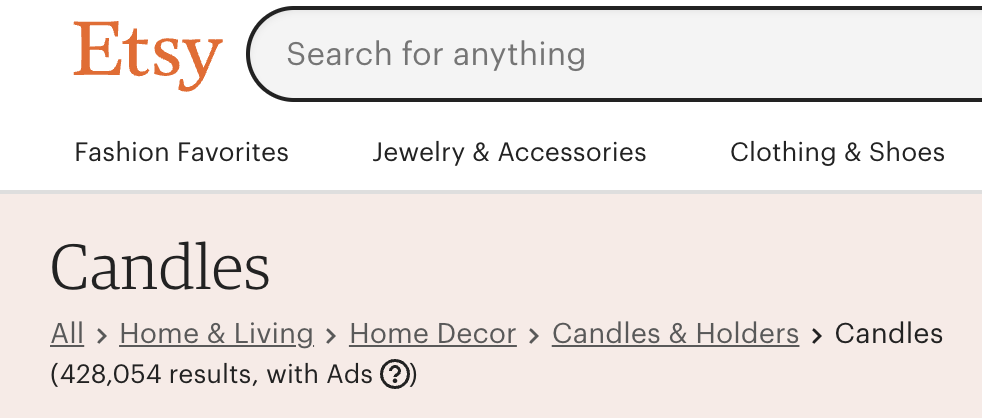

It is not clear how "relevancy" is calculated or determined by Etsy, but I chose to leave items ordered by "Relevancy" and scrape the first 4080 pages of results. The number of pages I decided to scrape was determined by my personal deadline to move on to the next phase of this project (in about 68 hours) and the fact that scraping 1 page of results takes about 1 minute.

When the data is scraped, I will check the distributions of other features of the data (price, recency, etc.) If necessary, I can augment the data with additional items (obtained via sorting by price or recency).

## Import Packages

We will use the built in Python package "requests" to make the initial HTTP request to the Etsy server. To parse the results, we will use a combination of the BeautifulSoup object from beautifulsoup4 to look for particular tags in the response, and the built in Python package "json" to parse the json within those tags.

In [3]:
import requests
import time # pause between requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import caffeine # leave computer on, but display off, while scraping script is running
from tqdm import tqdm # show a progress bar for scraping

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Summary of the Script

There are two primary tasks to be fulfilled in this script:

1.) Request and parse the results of the "search" for the given category, Candles. From this page, we can glean a good deal of product information as well as a URL for each product to request further information about the specific product.

2.) Request and parse the individual product page for each product in the category results.

The final data will be stored in a Pandas dataframe and saved to a file in the "Data" folder. Each row of the dataframe will correspond to a product, and each column will correspond to a feature (such as product name, description, brand, average rating, etc).

Additionally, to make this process as pain-free and efficient as possible, I need to build in some amount of error handling (so that a product without a brand or any ratings, for example, will not cause the script to stop running.)

It would probably also be wise to save the data periodically to prevent unexpected interruptions from causing the entire script to need to restart, and to give myself a way to start the script running from a specified point (rather than defaulting to page 1) without too much difficulty.

### Main Functions

The function `scrape_page` below accepts a URL for a page of results on Etsy, and returns a dataframe with various information about the products on that page.

In [4]:
def scrape_page(URL):
    '''Accepts a string version of the URL for search results from Etsy; returns a dataframe of products.'''
    # create a dictionary to hold information for each product on the page
    data = {'product_name': [],
            'product_url': [],
            'brand_type': [],
            'brand_name': [],
            'price': [],
            'currency': [],
            'position': [],
            'avg_rating': [],
            'review_count': [],
            'product_description': []}
    
    # send http request
    response = requests.get(URL)
    # process if successful
    if response.status_code==200:
        soup = BeautifulSoup(response.text)
        s = soup.find_all('script', type='application/ld+json')
        
        # list of products is second application ld+json script
        list_items = s[2]
        
        # preprocess json-format list_items to get a useable dictionary
        list_items = json.loads(str(list_items).strip('<script type=\"application/ld+json\">').strip('</script'))
        list_items = list_items['itemListElement']
        
        for item in list_items:
            # specify where to access data for each feature in http-returned dictionary
            # a list of strings indicates a multi-index (i.e. value is in a dictionary within a dictionary)
            item_keys = [
                ['name'], ['url'], ['brand', '@type'], ['brand', 'name'], ['offers', 'price'],
                ['offers', 'priceCurrency'], ['position'], ['aggregateRating', 'ratingValue'],
                ['aggregateRating', 'reviewCount'], ['productDescription']
            ]
            
            for feature, keys in zip(data.keys(), item_keys):
                try:
                    # this applies multiple keys in list if necessary
                    new_data = item
                    for key in keys:
                        # get product description when URL is provided
                        if key == 'url':
                            product_description = get_product_description(item['url'])
                        # assign product description to new data when key is productDescription
                        if key == 'productDescription':
                            new_data = product_description
                            break
                        new_data = new_data[key] # this will presumably cause an exception if key is not valid
                except:
                    new_data = None # in that case, append None
                
                # append new data to feature column in dataframe
                data[feature].append(new_data)
                
    return pd.DataFrame(data)

The sub-function `get_product_description` accepts the URL for a specific product's information page and returns the product description as a string.

In [5]:
def get_product_description(URL):
    '''Accepts a string for the individual product URL and returns the product description.'''
    
    product_response = requests.get(URL)
    
    if product_response.status_code==200:
        
        product_soup = BeautifulSoup(product_response.text)

        s = product_soup.find_all('script', type='application/ld+json')

        product_info = s[0]
        product_meta_content = s[1]

        product_info = json.loads(str(product_info).strip('<script type=\"application/ld+json\">').strip('</script'))
        
        return product_info['description']

Before I start scraping and storing data, the below cell creates an empty dataframe and saves it to a csv file in the Data folder. As each new page of results is scraped, I will append the new data to this csv file. (That way, if something unexpected happens mid-script and causes it to stop running, I can pick up where I left off easily without needing to re-run the script for earlier pages.) I am going to comment the cell out after running it the first time, so that I don't accidentally replace all of my hard work scraping data somehow later on. 🤪

In [5]:
# # ❗❗❗ DO NOT RE-RUN THIS CELL AFTER SCRAPING STARTS ❗❗❗

# # instantiate empty dataframe
# data = pd.DataFrame({'product_name': [],
#                      'product_url': [],
#                      'brand_type': [],
#                      'brand_name': [],
#                      'price': [],
#                      'currency': [],
#                      'position': [],
#                      'avg_rating': [],
#                      'review_count': [],
#                      'product_description': []})

# # save to file
# data.to_csv('Data/product_data.csv', index=False, header=True)

Scrape pages 1 through 4080 of the results for the "Candles" sub-category on Etsy (items are sorted by "Relevancy".)

In [7]:
%%time

caffeine.on(display=False)

for i in tqdm(range(1, 4081)):
    if i==1:
        URL = "https://www.etsy.com/c/home-and-living/home-decor/candles-and-holders/candles?explicit=1&ref=catcard-2791-264940576"
    else:
        URL = f"https://www.etsy.com/c/home-and-living/home-decor/candles-and-holders/candles?explicit=1"
        URL += "&ref=pagination&page={i}" # to fit on standard width page
        
    scrape_page(URL).to_csv('Data/product_data.csv', mode='a', index=False, header=False)

    time.sleep(3) # wait 3 seconds, to avoid overloading server with requests =)
    
caffeine.off()

  5%|█▉                                 | 222/4080 [5:29:14<95:21:34, 88.98s/it]


ConnectionError: HTTPSConnectionPool(host='www.etsy.com', port=443): Max retries exceeded with url: /c/home-and-living/home-decor/candles-and-holders/candles?explicit=1&ref=pagination&page=%7Bi%7D (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x129c3a310>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [9]:
caffeine.off()

In [8]:
print(i)

223

In [ ]:
%%time

caffeine.on(display=False)

for i in tqdm(range(223, 4081)):
    if i==1:
        URL = "https://www.etsy.com/c/home-and-living/home-decor/candles-and-holders/candles?explicit=1&ref=catcard-2791-264940576"
    else:
        URL = f"https://www.etsy.com/c/home-and-living/home-decor/candles-and-holders/candles?explicit=1"
        URL += "&ref=pagination&page={i}" # to fit on standard width page
        
    scrape_page(URL).to_csv('Data/product_data.csv', mode='a', index=False, header=False)

    time.sleep(3) # wait 3 seconds, to avoid overloading server with requests =)
    
caffeine.off()

 97%|█████████████████████████████ | 3740/3858 [62:58:55<128:40:51, 3925.86s/it]

Execution seemed to stop at page 3,962. To avoid losing the progress we've made if there are any issues appending further rows to the dataset on file, I am going to work with the data we have.

In [8]:
pd.read_csv('Data/product_data.csv')

,product_name,product_url,brand_type,brand_name,price,currency,position,avg_rating,review_count,product_description
0,Yellow Gold Rustic Unscented Pillar Candle - C...,https://www.etsy.com/listing/171033085/yellow-...,Brand,StillWaterCandles,16.00,USD,1,4.9284,3750.0,This large yellow gold rustic unscented pillar...
1,Pear Green Rustic Textured Unscented Block Pil...,https://www.etsy.com/listing/98864574/pear-gre...,Brand,StillWaterCandles,16.00,USD,2,4.9284,3750.0,This large pear green rustic unscented pillar ...
2,Burnt Orange Rustic Large Unscented Pillar Can...,https://www.etsy.com/listing/172053498/burnt-o...,Brand,StillWaterCandles,16.00,USD,3,4.9284,3750.0,This large burnt orange unscented rustic pilla...
3,Soy Mason Jar Candle////Choose Your Scent//Con...,https://www.etsy.com/listing/270002845/soy-mas...,Brand,TheDancingWick,15.00,USD,4,4.9323,29140.0,These beautiful candles are the perfect additi...
4,Rainbow Candle / Soy Candle with 6 colorful la...,https://www.etsy.com/listing/251774155/rainbow...,Brand,SoapForYourSoul,29.00,USD,5,4.9102,5057.0,Colorful rainbow candle is six layers of scent...
...,...,...,...,...,...,...,...,...,...,...
190123,"Pina Colada Soy Wax Candle, Amazing!!",NaN,Brand,LivingTreeCandles,45.00,USD,44,4.9380,2827.0,"He&#39;s got the 411...King, King of midnight ..."
190124,Our Lady of Diamonds and Rose Prayer Candle,https://www.etsy.com/listing/287533631/our-lad...,Brand,TheEternalFlame,20.00,USD,45,4.9833,5669.0,The gorgeous Saint of Diamonds and Rose and he...
190125,"Mermaid Soy Candle, Beach Candle, Personalized...",https://www.etsy.com/listing/503329278/mermaid...,Brand,KitschCandle,14.95,USD,46,4.9680,1259.0,Under the sea vintage mermaid candle!\n\nYou c...
190126,"Hand Poured Beeswax Turtle Candles, Two Box Tu...",https://www.etsy.com/listing/89216823/hand-pou...,Brand,GardenGateDesign,16.00,USD,47,4.9416,1072.0,These Beeswax Turtle Candles are so cute just ...
